# **Micro-Proyecto 2: Clustering**

**Integrantes:**
* Leonard David Vivas Dallos
* Nicolás Orozco Medina
* Tomás Escobar Rivera

En el trabajo en cuestión se va a hacer uso de un dataset que contiene las mejores 1000 reseñas de películas en IMDB. Este consta de información con 8 caracteristicas:

- ID: id
- name: Nombre de la película
- year: Año de estreno
- runtime: Duración de la película
- genre: Género de la película
- metascore: Metascore en IMDB
- rating: Calificaciones de IMDB
- timeline: Breve historia de la película
- votes: Total de votos obtenidos en IMDB
- gross: Recaudación en taquilla

Importamos librerías necesarias.

In [ ]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sb
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (25, 12)
plt.style.use('ggplot')

## 1. Exploración y Preprocesamiento de los datos

Cargamos el dataset

In [ ]:
# Para abrir desde colab
from google.colab import files
import io

uploaded = files.upload()
movies_df = pd.read_csv(io.BytesIO(uploaded["IMDB_movie_reviews_details.csv"]))

# Para abrir desde un IDE de escritorio
# movies_df=pd.read_csv('Taller5_iris.csv')
# movies_df.head()

#movies_df = pd.read_csv("IMDB_movie_reviews_details.csv")
movies_df.head()

Saving IMDB_movie_reviews_details.csv to IMDB_movie_reviews_details.csv


,Unnamed: 0,name,year,runtime,genre,rating,metascore,timeline,votes,gross
0,0,The Shawshank Redemption,1994,142,Drama,9.3,80.0,Two imprisoned men bond over a number of years...,"2,394,059",$28.34M
1,1,The Godfather,1972,175,"Crime, Drama",9.2,100.0,An organized crime dynasty's aging patriarch t...,"1,658,439",$134.97M
2,2,Soorarai Pottru,2020,153,Drama,9.1,NaN,"Nedumaaran Rajangam ""Maara"" sets out to make t...","78,266",NaN
3,3,The Dark Knight,2008,152,"Action, Crime, Drama",9.0,84.0,When the menace known as the Joker wreaks havo...,"2,355,907",$534.86M
4,4,The Godfather: Part II,1974,202,"Crime, Drama",9.0,90.0,The early life and career of Vito Corleone in ...,"1,152,912",$57.30M


En primer lugar, con una simple mirada de los datos, nos damos cuenta de algunas de las características del dataset. En principio, se tiene una columna llamada "Unnamed: 0" que hace referencia al ID de cada película, esta la vamos a usar como índice del mismo.

In [ ]:
movies_df = movies_df.set_index("Unnamed: 0")
movies_df.head()

,name,year,runtime,genre,rating,metascore,timeline,votes,gross
Unnamed: 0,,,,,,,,,
0,The Shawshank Redemption,1994,142,Drama,9.3,80.0,Two imprisoned men bond over a number of years...,"2,394,059",$28.34M
1,The Godfather,1972,175,"Crime, Drama",9.2,100.0,An organized crime dynasty's aging patriarch t...,"1,658,439",$134.97M
2,Soorarai Pottru,2020,153,Drama,9.1,NaN,"Nedumaaran Rajangam ""Maara"" sets out to make t...","78,266",NaN
3,The Dark Knight,2008,152,"Action, Crime, Drama",9.0,84.0,When the menace known as the Joker wreaks havo...,"2,355,907",$534.86M
4,The Godfather: Part II,1974,202,"Crime, Drama",9.0,90.0,The early life and career of Vito Corleone in ...,"1,152,912",$57.30M


In [ ]:
movies_df.tail()

,name,year,runtime,genre,rating,metascore,timeline,votes,gross
Unnamed: 0,,,,,,,,,
995,Breakfast at Tiffany's,1961,115,"Comedy, Drama, Romance",7.6,76.0,A young New York socialite becomes interested ...,"169,575",NaN
996,Giant,1956,201,"Drama, Western",7.6,84.0,Sprawling epic covering the life of a Texas ca...,"34,759",NaN
997,Shane,1953,118,"Drama, Western",7.6,80.0,A weary gunfighter attempts to settle down wit...,"37,753",$20.00M
998,From Here to Eternity,1953,118,"Drama, Romance, War",7.6,85.0,"In Hawaii in 1941, a private is cruelly punish...","44,086",$30.50M
999,Lifeboat,1944,97,"Drama, War",7.6,78.0,Several survivors of a torpedoed merchant ship...,"26,903",NaN


Con el atributo `.shape` vemos que el conjunto de datos está compuesto por 1000 registros correspondientes a 1000 películas particulares con sus respectivas reseñas.

Cada registro tiene 10 columnas, el id de la misma, su nombre y las 8 características de cada una.

In [ ]:
movies_df.shape

(1000, 9)

Se sugiere mezclar los datos de forma aleatoria antes de realizar cualquier otro tipo de preprocesamiento. (Esta mezcla de los datos implica la pérdida de la columna ID, algo no importante para nuestro estudio)

In [ ]:
# Mezclar el DataFrame
movies_df = movies_df.sample(frac=1).reset_index(drop=True)

movies_df.head()

,name,year,runtime,genre,rating,metascore,timeline,votes,gross
0,Wonder,I 2017,113,"Drama, Family",8.0,66.0,"Based on the New York Times bestseller, this m...","147,185",$132.42M
1,Brokeback Mountain,2005,134,"Drama, Romance",7.7,87.0,Ennis and Jack are two shepherds who develop a...,"329,316",$83.04M
2,Training Day,2001,122,"Crime, Drama, Thriller",7.7,69.0,A rookie cop spends his first day as a Los Ang...,"399,865",$76.63M
3,The Virgin Spring,1960,89,Drama,8.1,NaN,An innocent yet pampered young virgin and her ...,"27,225",$1.53M
4,The Magnificent Seven,1960,128,"Action, Adventure, Western",7.7,74.0,Seven gunfighters are hired by Mexican peasant...,"89,005",$4.91M



Para hacernos una idea de qué características podríamos usar para el clustering exploremos más los datos.

In [ ]:
print(movies_df.groupby('genre').size())

genre
Action, Adventure                5
Action, Adventure, Biography     1
Action, Adventure, Comedy       10
Action, Adventure, Crime         1
Action, Adventure, Drama        14
                                ..
Mystery, Romance, Thriller       1
Mystery, Sci-Fi, Thriller        1
Mystery, Thriller                9
Thriller                         1
Western                          4
Length: 203, dtype: int64


In [ ]:
largest_group = movies_df.groupby('genre').size()
print(f"Grupo más grande: {largest_group.idxmax()}, Count: {largest_group.max()}")

Grupo más grande: Drama, Count: 88


Como podemos observar hay una gran variedad en los géneros de películas, así que hacer una clasificación con esta característica podría resultar un poco difícil, pero no hay que descartarla aún (posiblemente, el uso del primero de los géneros podría servir de ayuda)

Por otro lado, observando el dataset, podemos notar que el formato de algunas de las características resulta complejo de trabajar. En principio, sabemos que podemos descartar la característica "timeline", pues habla netamente de una descripción de las películas, algo que no es de ayuda en nuestro trabajo de clasificación. Además de esto, debemos tener cuidado con el formato de algunas columnas, por ejemplo, en la columna "gross" tenemos información monetaria, que deberiamos pasar a valores numéricos, de igual manera sucede con la cantidad de votos. Así que, realicemos este pequeño preprocesamiento de los datos para ver en que situación nos encontramos.

In [ ]:
# Preprocesamiento inicial de los datos

# Eliminamos la columna timeline
movies_df = movies_df.drop(columns=['timeline'])

# Manejo en el tipo de datos de la columna gross
def convert_gross(value):
    if 'M' in value:
        return float(value.replace('M', '').replace('$', '').replace(',', '')) * 1e6
    elif 'K' in value:
        return float(value.replace('K', '').replace('$', '').replace(',', '')) * 1e3
    else:
        return float(value.replace('$', '').replace(',', ''))

movies_df['gross'] = movies_df['gross'].dropna().apply(convert_gross)

# Tipo de datos de la columna votes
movies_df['votes'] = movies_df['votes'].str.replace(',', '').astype(float)


In [ ]:
# Visualizamos de los datos
movies_df.head()

,name,year,runtime,genre,rating,metascore,votes,gross
0,Wonder,I 2017,113,"Drama, Family",8.0,66.0,147185.0,132420000.0
1,Brokeback Mountain,2005,134,"Drama, Romance",7.7,87.0,329316.0,83040000.0
2,Training Day,2001,122,"Crime, Drama, Thriller",7.7,69.0,399865.0,76630000.0
3,The Virgin Spring,1960,89,Drama,8.1,NaN,27225.0,1530000.0
4,The Magnificent Seven,1960,128,"Action, Adventure, Western",7.7,74.0,89005.0,4910000.0


Por otro lado, podemos ver que algunas de las películas de las cuales se tiene información tienen información faltante, estas películas podrían impactar de manera negativa en nuestro análisis. Siendo así, eliminemos estos registros y veamos con que registros contamos.

In [ ]:
# Eliminamos los registros nulos
movies_df = movies_df.dropna()
movies_df.head()

,name,year,runtime,genre,rating,metascore,votes,gross
0,Wonder,I 2017,113,"Drama, Family",8.0,66.0,147185.0,132420000.0
1,Brokeback Mountain,2005,134,"Drama, Romance",7.7,87.0,329316.0,83040000.0
2,Training Day,2001,122,"Crime, Drama, Thriller",7.7,69.0,399865.0,76630000.0
4,The Magnificent Seven,1960,128,"Action, Adventure, Western",7.7,74.0,89005.0,4910000.0
5,"O Brother, Where Art Thou?",2000,107,"Adventure, Comedy, Crime",7.7,69.0,292711.0,45510000.0


In [ ]:
movies_df.reset_index(drop=True, inplace=True)
movies_df.head()

,name,year,runtime,genre,rating,metascore,votes,gross
0,Wonder,I 2017,113,"Drama, Family",8.0,66.0,147185.0,132420000.0
1,Brokeback Mountain,2005,134,"Drama, Romance",7.7,87.0,329316.0,83040000.0
2,Training Day,2001,122,"Crime, Drama, Thriller",7.7,69.0,399865.0,76630000.0
3,The Magnificent Seven,1960,128,"Action, Adventure, Western",7.7,74.0,89005.0,4910000.0
4,"O Brother, Where Art Thou?",2000,107,"Adventure, Comedy, Crime",7.7,69.0,292711.0,45510000.0


In [ ]:
movies_df.shape

(747, 8)

Como podemos ver, luego del preprocesamiento inicial de los datos, contamos con 747 registros para realizar su análisis. En principio, veamos si cambió en algo la distribución de los géneros

In [ ]:
print(movies_df.groupby('genre').size())

genre
Action, Adventure              5
Action, Adventure, Comedy      7
Action, Adventure, Drama      12
Action, Adventure, Family      1
Action, Adventure, Fantasy     6
                              ..
Mystery, Romance, Thriller     1
Mystery, Sci-Fi, Thriller      1
Mystery, Thriller              4
Thriller                       1
Western                        4
Length: 175, dtype: int64


In [ ]:
largest_group = movies_df.groupby('genre').size()
print(f"Grupo más grande: {largest_group.idxmax()}, Count: {largest_group.max()}")

Grupo más grande: Drama, Count: 67


Según parece aún tenemos bastantes géneros, y el grupo más grande sigue siendo Drama, realicemos una prueba, quedándonos con el primer género de cada película, que resulta ser siempre el género principal de la misma, con el fin de ver si nos sirve de ayuda en nuestro proceso.

In [ ]:
# Preprocesamiento alternativo para los géneros
movies_df_aux = movies_df.copy()
movies_df_aux['genre'] = movies_df_aux['genre'].str.split(',').str[0]

movies_df_aux.head()

,name,year,runtime,genre,rating,metascore,votes,gross
0,Wonder,I 2017,113,Drama,8.0,66.0,147185.0,132420000.0
1,Brokeback Mountain,2005,134,Drama,7.7,87.0,329316.0,83040000.0
2,Training Day,2001,122,Crime,7.7,69.0,399865.0,76630000.0
3,The Magnificent Seven,1960,128,Action,7.7,74.0,89005.0,4910000.0
4,"O Brother, Where Art Thou?",2000,107,Adventure,7.7,69.0,292711.0,45510000.0


In [ ]:
print(movies_df_aux.groupby('genre').size())

genre
Action       128
Adventure     55
Animation     65
Biography     71
Comedy       109
Crime         83
Drama        210
Family         2
Fantasy        1
Film-Noir      1
Horror        11
Mystery        6
Thriller       1
Western        4
dtype: int64


In [ ]:
largest_group_aux = movies_df_aux.groupby('genre').size()
print(f"Grupo más grande: {largest_group_aux.idxmax()}, Count: {largest_group_aux.max()}")

Grupo más grande: Drama, Count: 210


Como podemos ver, esta especie de filtro en los géneros de las películas reduce bastante la cantidad de géneros en este tipo, esto podría resultar ser de ayuda más adelante, por lo que procederemos a convertir los géneros que tenemos a un valor numérico

In [ ]:
# Conversión de los géneros obtenidos a numérico
label_encoder = preprocessing.LabelEncoder()
movies_df_aux['genre'] = label_encoder.fit_transform(movies_df_aux['genre'].astype(str))

movies_df_aux.head()

,name,year,runtime,genre,rating,metascore,votes,gross
0,Wonder,I 2017,113,6,8.0,66.0,147185.0,132420000.0
1,Brokeback Mountain,2005,134,6,7.7,87.0,329316.0,83040000.0
2,Training Day,2001,122,5,7.7,69.0,399865.0,76630000.0
3,The Magnificent Seven,1960,128,0,7.7,74.0,89005.0,4910000.0
4,"O Brother, Where Art Thou?",2000,107,1,7.7,69.0,292711.0,45510000.0


Para deducir un poco la asignación que se realizó, mostremos nuevamente las cantidades de cada grupo, haciendo un cotejo de ambas tablas podremos fácilmente deducir esta tipología.

In [ ]:
print(movies_df_aux.groupby('genre').size())

genre
0     128
1      55
2      65
3      71
4     109
5      83
6     210
7       2
8       1
9       1
10     11
11      6
12      1
13      4
dtype: int64


Así pues, la situación con la que nos encontramos es con un dataset con 747 datos de películas, cada una con su nombre y 7 características que nos ayudarán a hacer un debido análisis de las mismas.
Ahora, visualicemos un poco algunas de las características en un único gráfico 3D para darnos una idea de la situación

In [ ]:
# Definir una función para el gráfico de dispersión en 3D
def plot_3d_scatter(data, x_col, y_col, z_col, color_col, size_col=None):
    """
    Genera un gráfico de dispersión en 3D utilizando Plotly Express.

    Parámetros:
    - data (DataFrame): El conjunto de datos a graficar.
    - x_col (str): Nombre de la columna para el eje x.
    - y_col (str): Nombre de la columna para el eje y.
    - z_col (str): Nombre de la columna para el eje z.
    - color_col (str): Nombre de la columna para asignar colores a los puntos.
    - size_col (str, opcional): Nombre de la columna para determinar el tamaño de los puntos. Por defecto es None.

    Retorna:
    - Ninguno. Muestra el gráfico de dispersión en 3D.
    """

    # Generar el gráfico de dispersión en 3D
    fig = px.scatter_3d(
        data,
        x=x_col,
        y=y_col,
        z=z_col,
        color=color_col,
        size=size_col,
        title="Gráfico de Dispersión 3D",
    )
    fig.show()

test_cases = [
    {"x_col": "year", "y_col": "metascore", "z_col": "rating", "color_col": "genre"},
]

for test in test_cases:
    print(f"Generando gráfico con {test}")
    plot_3d_scatter(
        data=movies_df,
        x_col=test["x_col"],
        y_col=test["y_col"],
        z_col=test["z_col"],
        color_col=test["color_col"],
        size_col=test.get("size_col"),
    )

Generando gráfico con {'x_col': 'year', 'y_col': 'metascore', 'z_col': 'rating', 'color_col': 'genre'}


### Visualizando los datos

Matriz de correlación

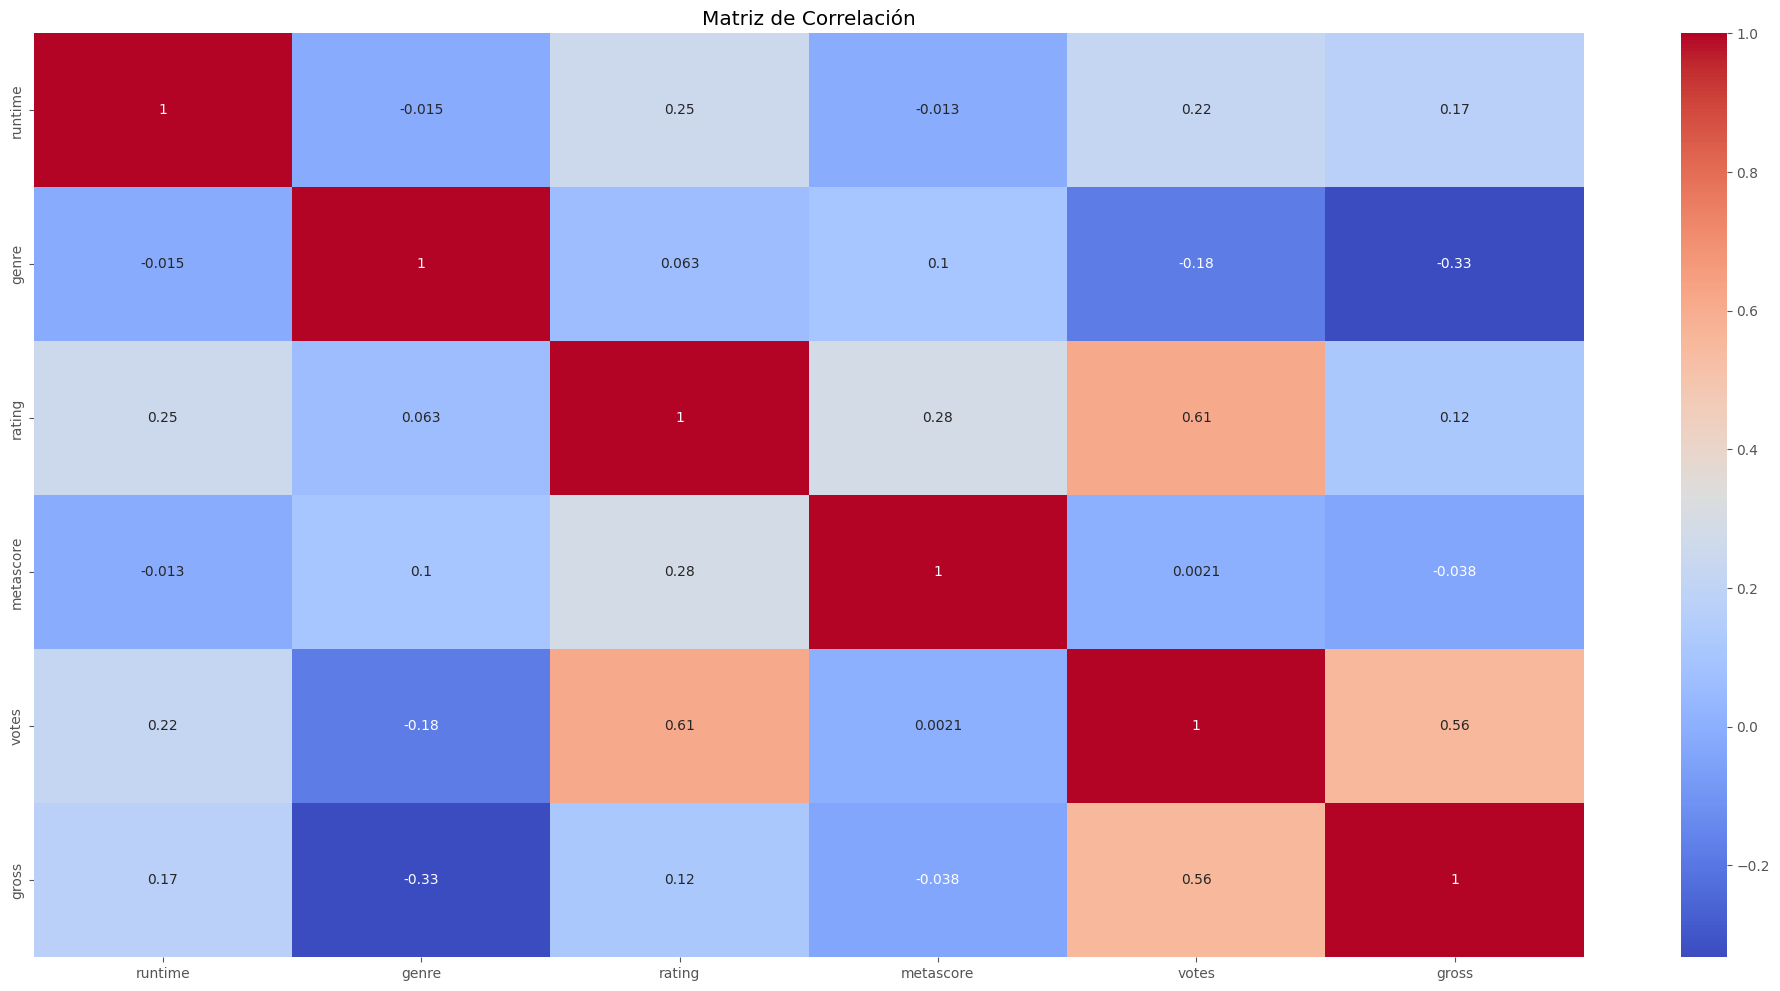

In [ ]:
# Seleccionar solo las columnas numéricas
numeric_cols = movies_df_aux.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
corrMatrix = numeric_cols.corr()

# Graficar el heatmap de la matriz de correlación
sb.heatmap(corrMatrix, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

También podemos usar una matriz de dispersión para ver cómo se relacionan los datos.

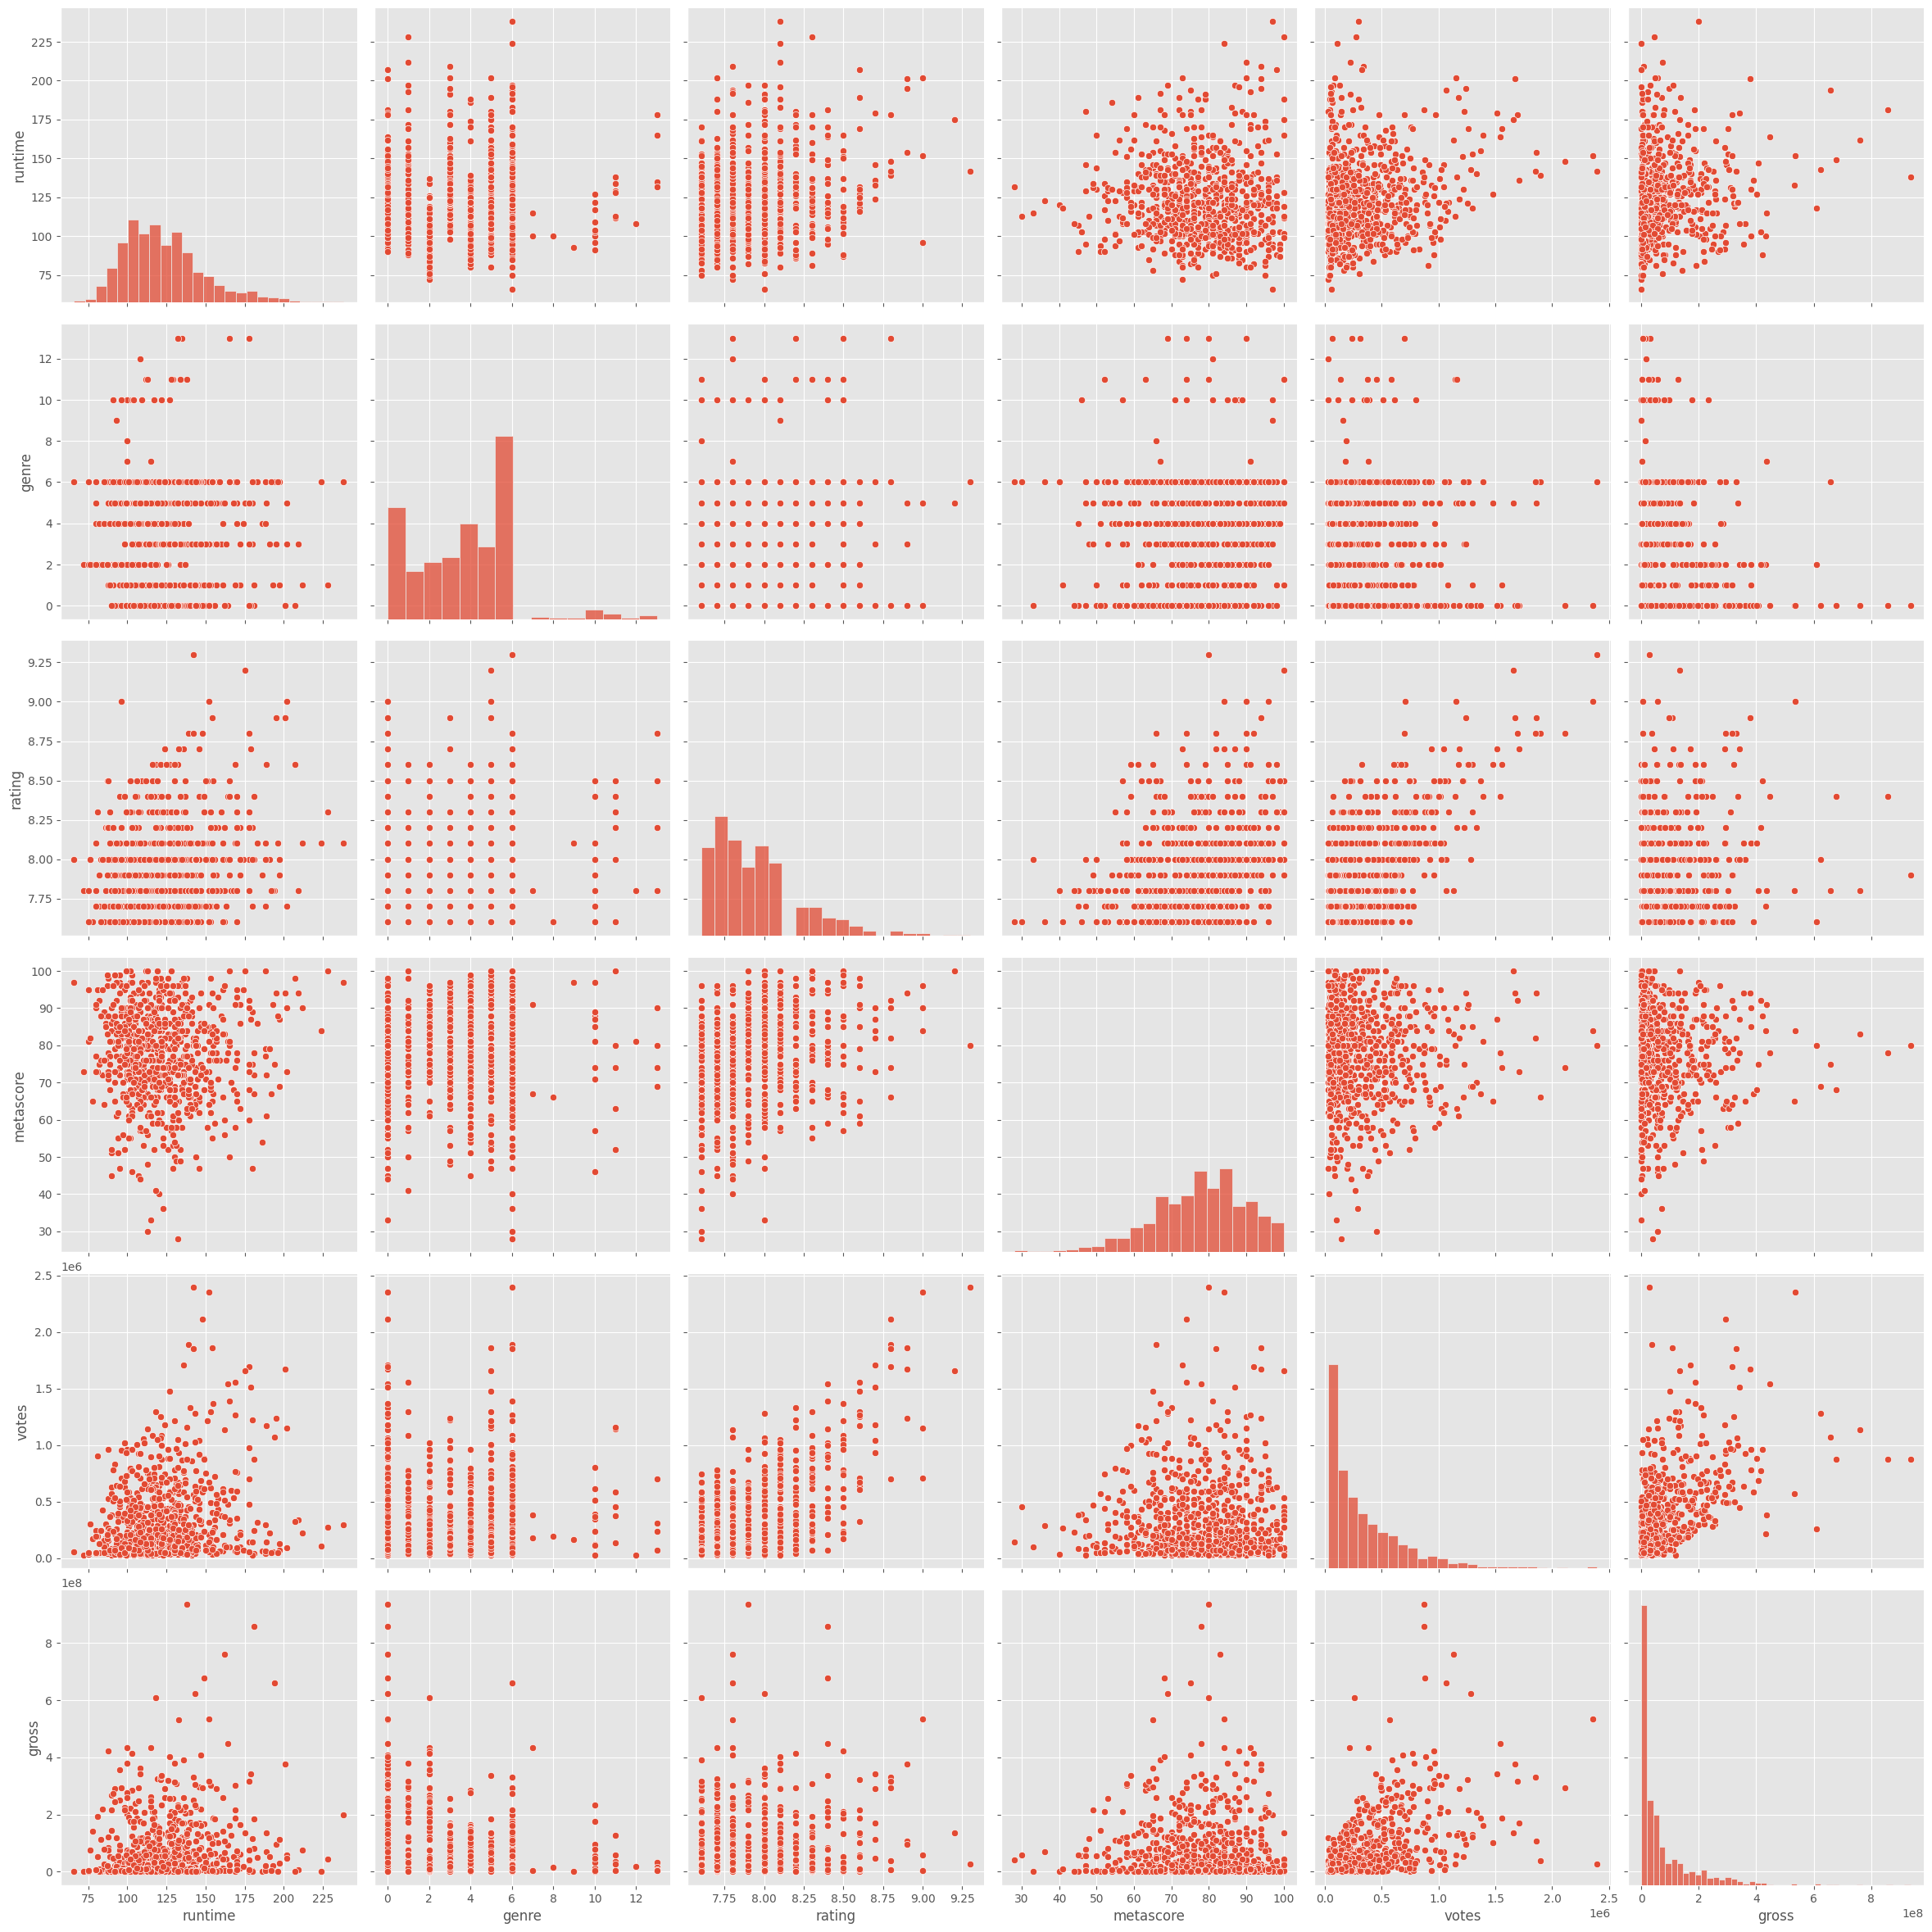

In [ ]:
# Crear el pairplot con las columnas numéricas
sb.pairplot(movies_df_aux, height=4, vars=numeric_cols.columns, kind='scatter')
plt.show()

Las características *votes*, *metascore*, y *gross* son buenas candidatas para realizar clustering en el dataset, ya que representan diferentes aspectos del éxito y popularidad de las películas. Además, como podemos ver en las imágenes de las gráficas de las matrices de dispersión, son los datos en los cuales se llega a notar una leve segmentación de los datos.

Siendo así, visualicemos nuevamente los datos en un gráfico 3D, con las características que deseamos usar para nuestro análisis.

In [ ]:
test_cases = [
        {"x_col": "rating", "y_col": "metascore", "z_col": "gross", "color_col": "genre"},
    ]

for test in test_cases:
    print(f"Generando gráfico con {test}")
    plot_3d_scatter(
        data=movies_df_aux,
        x_col=test["x_col"],
        y_col=test["y_col"],
        z_col=test["z_col"],
        color_col=test["color_col"],
        size_col=test.get("size_col"),
    )

Generando gráfico con {'x_col': 'rating', 'y_col': 'metascore', 'z_col': 'gross', 'color_col': 'genre'}


In [ ]:
test_cases = [
        {"x_col": "votes", "y_col": "metascore", "z_col": "gross", "color_col": "genre"},
    ]

for test in test_cases:
    print(f"Generando gráfico con {test}")
    plot_3d_scatter(
        data=movies_df_aux,
        x_col=test["x_col"],
        y_col=test["y_col"],
        z_col=test["z_col"],
        color_col=test["color_col"],
        size_col=test.get("size_col"),
    )

Generando gráfico con {'x_col': 'votes', 'y_col': 'metascore', 'z_col': 'gross', 'color_col': 'genre'}


## 2. Cantidad óptima de clusters

Usando 3 variables: votes, metascore, y gross.

In [ ]:
# Seleccionar las características para clustering
features = ['votes', 'metascore', 'gross']
clustering_data = movies_df_aux[features]

# Convertir a np.array
clustering_data_array = clustering_data.values

# Normalizar los datos
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data_array)

# clustering_data_scaled = normalize(clustering_data)
# clustering_data_scaled = pd.DataFrame(clustering_data_scaled, columns = clustering_data.columns)

### Elbow Curve

In [ ]:
# Definimos la cantidad de clusters con los queremos probar
maxClusters = 10

In [ ]:
def elbow_curve(data, maxClusters = 15):

  # rango de valores del parámetro a optimizar (cantidad de clusters)
  maxClusters = range(1, maxClusters + 1)
  inertias = []

  # se ejecuta el modelo para el rango de clusters y se guarda la inercia
  # respectiva obtenida para cada valor
  for k in maxClusters:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(clustering_data_scaled)
    inertias.append(kmeanModel.inertia_)

  # Grafico de los resultados obtenidos para cada valor del rango
  print("Valores: ",inertias)
  plt.figure(figsize=(10, 8))
  plt.plot(maxClusters, inertias, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

Valores:  [2241.000000000001, 1458.1220833097575, 1045.7104554500133, 870.5468386268981, 752.8678389224199, 646.3659245744005, 549.7940231505315, 502.46855190096454, 467.69226768194045, 422.2392771879839]


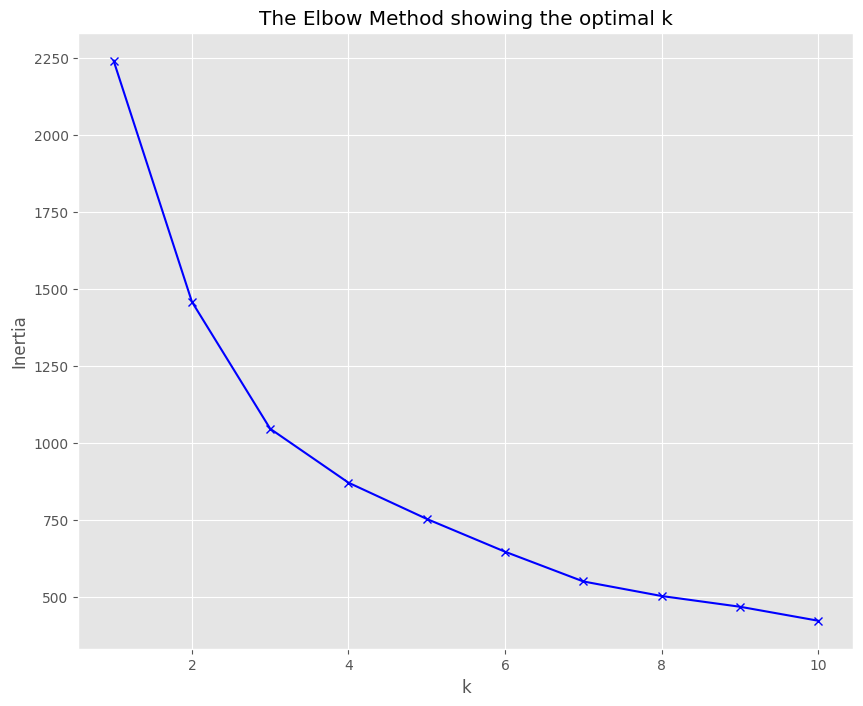

In [ ]:
elbow_curve(clustering_data_scaled, maxClusters = 10)

En el gráfico se puede ver claramente que a partir de k = 3 ya no hay una mejoría significativa en la reducción de la variación intra-cluster (inercia), por lo tanto, según este método, la cantidad óptima de clusters para agrupar estos datos es dos.

### Estadístico de Gap

El objetivo de este método es definir un procedimiento estadístico para formalizar la heurística de la curva de codo. De forma muy simplificada, el estadístico de gap compara, para diferentes valores de k, la variación total intracluster observada frente al valor esperado acorde a una distribución uniforme de referencia (datos de referencia).

El valor a elegir será el k mas pequeño tal que en k+1 el gráfico caiga (no necesariamente es el máximo absoluto de la curva de gap).

In [ ]:
def optimalK(data, nrefs=3, maxClusters=15):
    gaps = np.zeros((len(range(1, maxClusters+1)),))
    results_list = []

    for gap_index, k in enumerate(range(1, maxClusters+1)):
        # Guardará los resultados de dispersión de cada distribución simulada
        refDisps = np.zeros(nrefs)

        # Genera las muestras aleatorias indicadas con nrefs y ejecuta k-means
        # en cada bucle obteniendo los resultados de dispersión (inercia)
        # para cada conjunto generado.
        for i in range(nrefs):
            # Crea nuevo conjunto aleatorio de referencia
            np.random.seed(0)
            randomReference = np.random.random_sample(size=data.shape)

            # Ajusta el modelo al conjunto de referencia
            km = KMeans(k)
            km.fit(randomReference)
            # Guarda la dispersión obtenida
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Ajusta el modelo a los datos originales y guarda su inercia
        km = KMeans(k)
        km.fit(data)

        origDisp = km.inertia_

        # Calcula el estadístico de gap para k clusters usando el promedio de
        # las dispersiones de los datos simulados y la dispersión de los datos originales.
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Guarda el estadístico de gap obtenido en este bucle.
        gaps[gap_index] = gap

        results_list.append({'clusterCount': k, 'gap': gap})

    resultsdf = pd.DataFrame(results_list)

    # Selecciona el "primer máximo" de los estadísticos obtenidos y devuelve
    # su respectivo número de clusters
    for i in range(0, len(gaps)-1):
        if gaps[i+1] <= gaps[i]:
            return (i+1, resultsdf)
    return (len(gaps), resultsdf)

In [ ]:
k, gapdf = optimalK(clustering_data_scaled, nrefs=5, maxClusters=10)
print('La cantidad óptima de clusters es: ', k)

La cantidad óptima de clusters es:  3


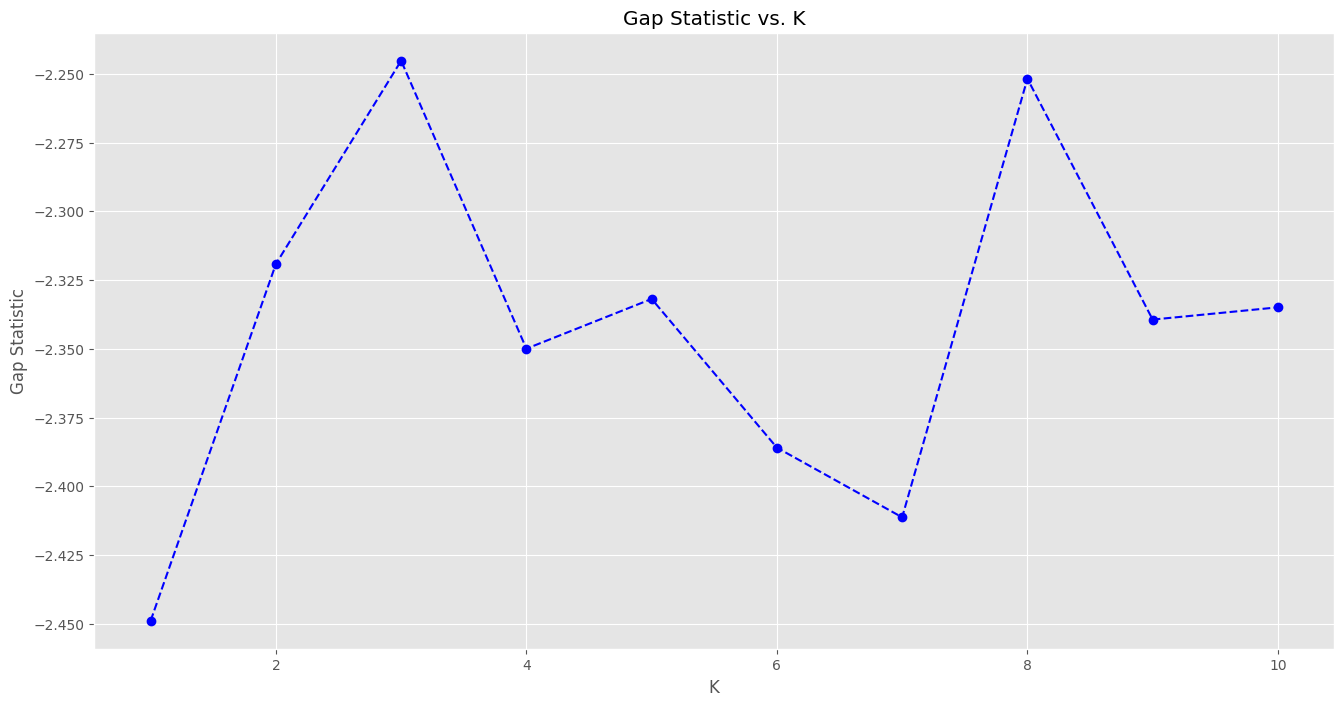

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(gapdf['clusterCount'], gapdf['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

En el grafico se puede ver como k = 3 es el valor más alto.

### Coeficiente de Silueta

Para n_clusters = 2 El promedio del coeficiente de silueta es: 0.44623446271947187
Para n_clusters = 3 El promedio del coeficiente de silueta es: 0.3391992395596726
Para n_clusters = 4 El promedio del coeficiente de silueta es: 0.34636435405496396
Para n_clusters = 5 El promedio del coeficiente de silueta es: 0.3556460652375716
Para n_clusters = 6 El promedio del coeficiente de silueta es: 0.3204999665245756


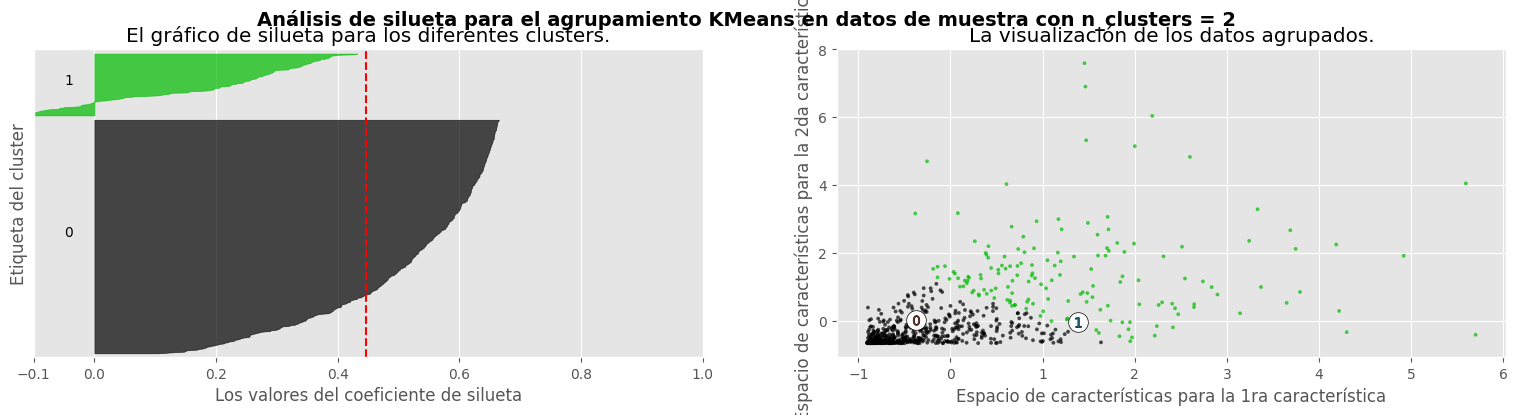

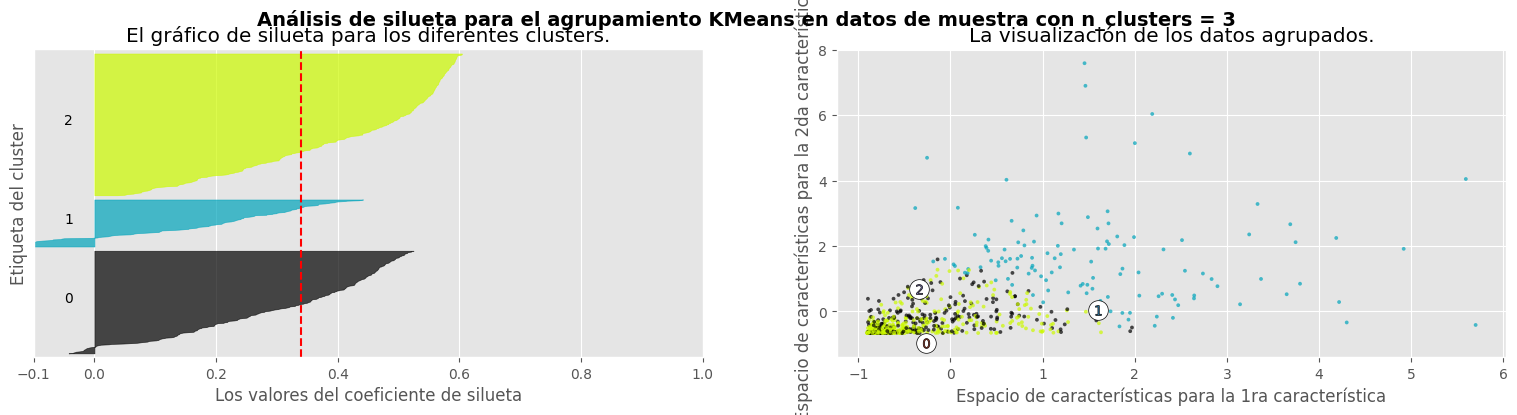

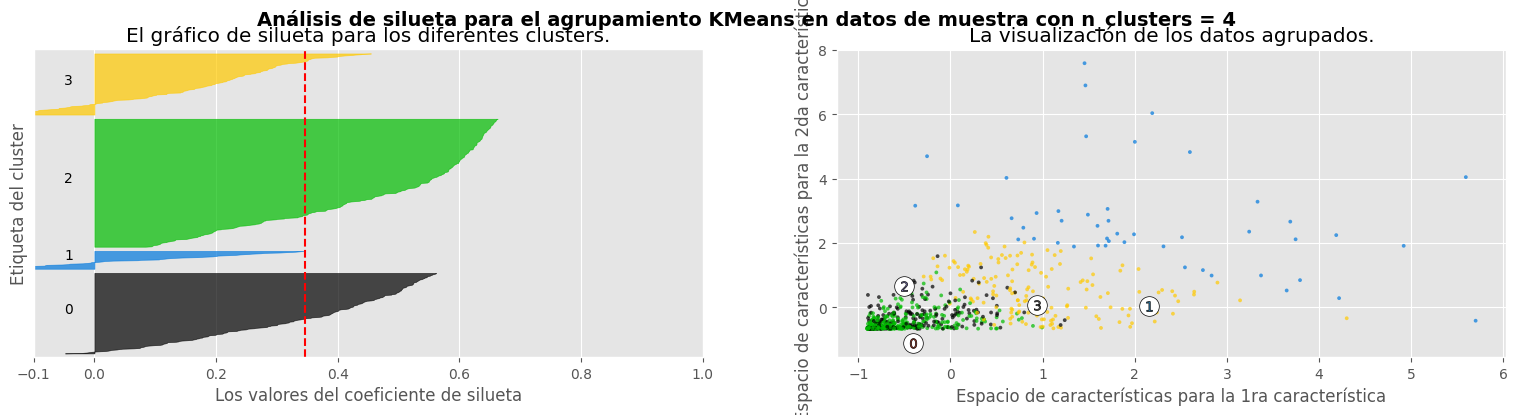

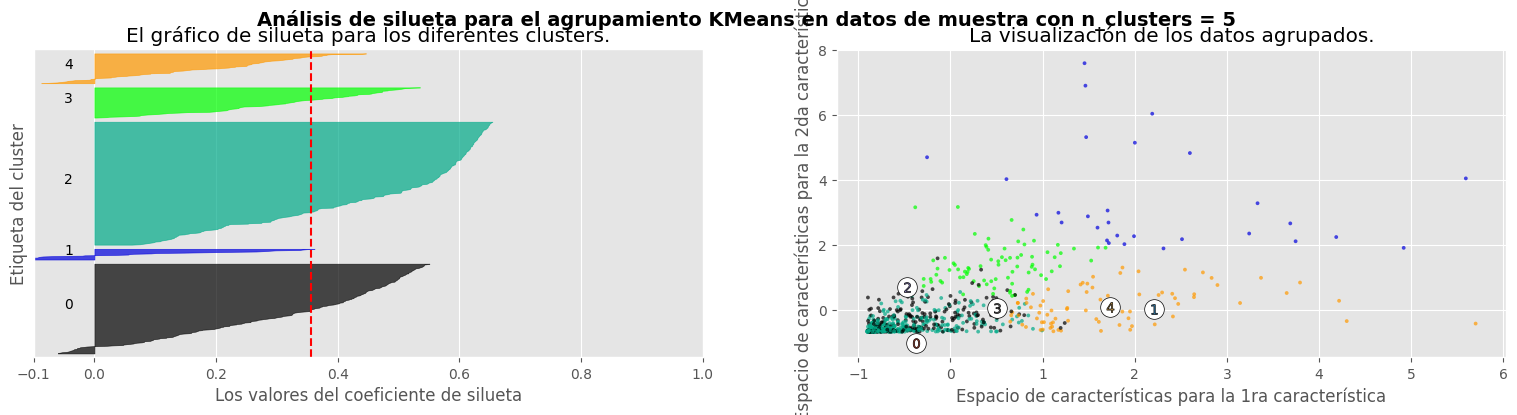

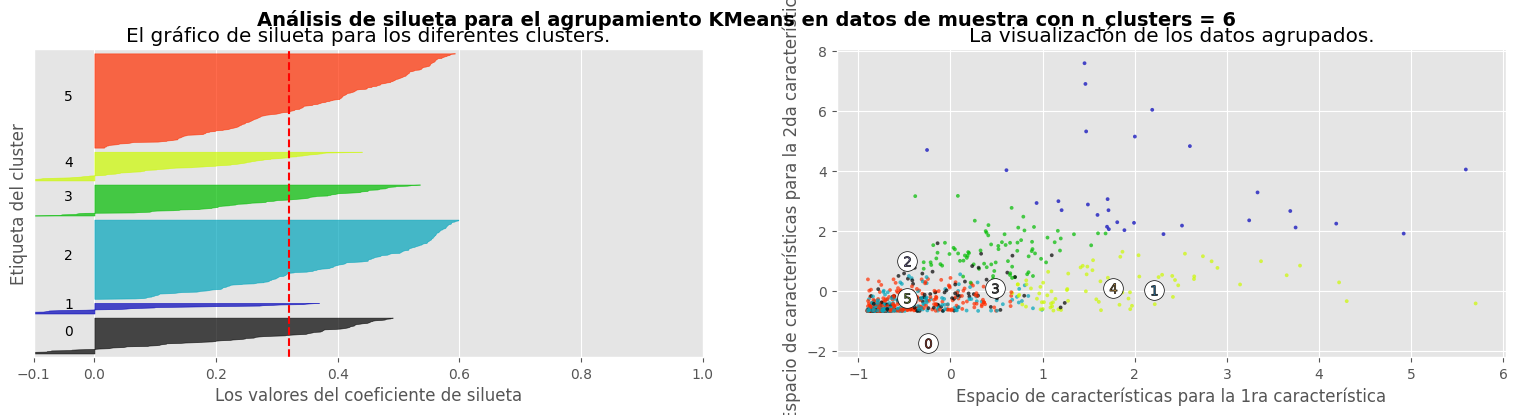

In [ ]:
colores_k_means = ['cyan','purple','orange']
rango_n_clusters = [2, 3, 4, 5, 6]
X = clustering_data_scaled

for n_clusters in rango_n_clusters:
    # Crear un subplot con 1 fila y 2 columnas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(19, 4)

    # El primer subplot es el gráfico de silueta
    # El coeficiente de silueta puede variar de -1 a 1, pero en este ejemplo todos
    # están dentro del rango [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # El (n_clusters+1)*10 es para insertar espacio en blanco entre los gráficos de silueta
    # de los clusters individuales, para demarcarlos claramente.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Inicializar el agrupador con el valor de n_clusters y una semilla de generador aleatorio
    # de 10 para reproducibilidad.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    etiquetas_cluster = clusterer.fit_predict(X)

    # El silhouette_score da el valor promedio para todas las muestras.
    # Esto da una perspectiva sobre la densidad y separación de los clusters formados
    silueta_promedio = silhouette_score(X, etiquetas_cluster)
    print("Para n_clusters =", n_clusters,
          "El promedio del coeficiente de silueta es:", silueta_promedio)

    # Calcular los valores de silueta para cada muestra
    valores_silueta_muestra = silhouette_samples(X, etiquetas_cluster)

    y_lower = 10
    for i in range(n_clusters):
        # Agregar los valores de silueta para las muestras que pertenecen al
        # cluster i, y ordenarlos
        valores_silueta_cluster_i = \
            valores_silueta_muestra[etiquetas_cluster == i]

        valores_silueta_cluster_i.sort()

        tamaño_cluster_i = valores_silueta_cluster_i.shape[0]
        y_upper = y_lower + tamaño_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, valores_silueta_cluster_i,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquetar los gráficos de silueta con sus números de cluster en el medio
        ax1.text(-0.05, y_lower + 0.5 * tamaño_cluster_i, str(i))

        # Calcular el nuevo y_lower para el siguiente gráfico
        y_lower = y_upper + 10  # 10 para las muestras 0

    ax1.set_title("El gráfico de silueta para los diferentes clusters.")
    ax1.set_xlabel("Los valores del coeficiente de silueta")
    ax1.set_ylabel("Etiqueta del cluster")

    # La línea vertical para el promedio del coeficiente de silueta de todos los valores
    ax1.axvline(x=silueta_promedio, color="red", linestyle="--")

    ax1.set_yticks([])  # Limpiar las etiquetas/ticks del eje y
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Segundo gráfico que muestra los clusters formados
    colores = plt.cm.nipy_spectral(etiquetas_cluster.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colores, edgecolor='k')

    # Etiquetar los clusters
    centros = clusterer.cluster_centers_
    # Dibujar círculos blancos en los centros de los clusters
    ax2.scatter(centros[:, 0], centros[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centros):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("La visualización de los datos agrupados.")
    ax2.set_xlabel("Espacio de características para la 1ra característica")
    ax2.set_ylabel("Espacio de características para la 2da característica")

    plt.suptitle(("Análisis de silueta para el agrupamiento KMeans en datos de muestra "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Podemos ver que los puntajes mas altos se obtuvieron para 2 y 3 clusters, teniendo en cuenta todos los métodos realizados para determinar un óptimo, nos parece prudente usar un k = 3, ya que, es el tamaño que parece ser mas constante para todos los análisis.

### Resultados Obtenidos

Entonces usamos k-means con k = 3.

In [ ]:
kmeans_model_3D = KMeans(n_clusters=3, max_iter=1000).fit(clustering_data_scaled)
labels_3D = kmeans_model_3D.labels_
centroids_3D = kmeans_model_3D.cluster_centers_

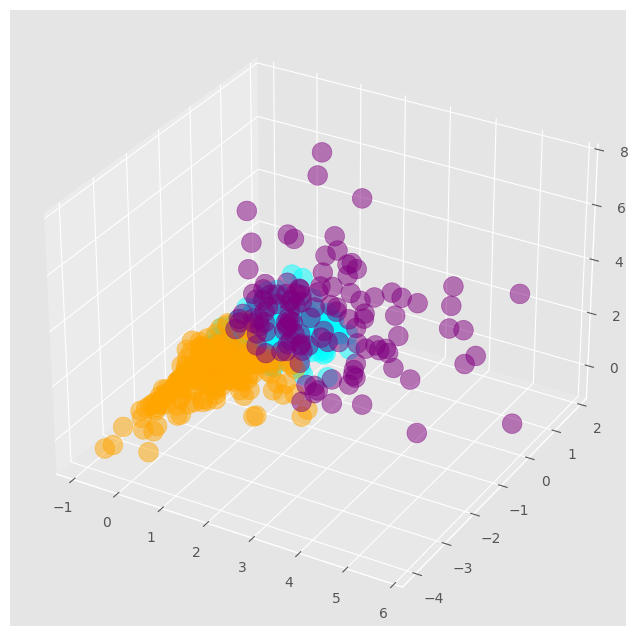

In [ ]:
# Crear una nueva figura
fig = plt.figure(figsize=(10, 8))

# Añadir un subplot 3D
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos
ax.scatter(clustering_data_scaled[:, 0], clustering_data_scaled[:, 1], clustering_data_scaled[:, 2],
           c=labels_3D, s=200, cmap=matplotlib.colors.ListedColormap(colores_k_means), alpha=0.5)

# Graficar los centroides
ax.scatter(centroids_3D[:, 0], centroids_3D[:, 1], centroids_3D[:, 2],
           marker='*', c='r', s=300)

# Mostrar la gráfica
plt.show()

In [ ]:
# Crear un DataFrame con los datos
data = pd.DataFrame({
    'x': clustering_data_scaled[:, 0],
    'y': clustering_data_scaled[:, 1],
    'z': clustering_data_scaled[:, 2],
    'color': labels_3D,
    'size': [200] * len(clustering_data_scaled)  # Tamaño constante para los puntos
})

# Graficar los puntos con scatter_3d
fig = px.scatter_3d(
    data,
    x='x',
    y='y',
    z='z',
    color='color',
    size='size',
    title="Gráfico de Dispersión 3D",
    opacity=0.5
)

fig.show()

## 3. Agrupamiento Jerárquico

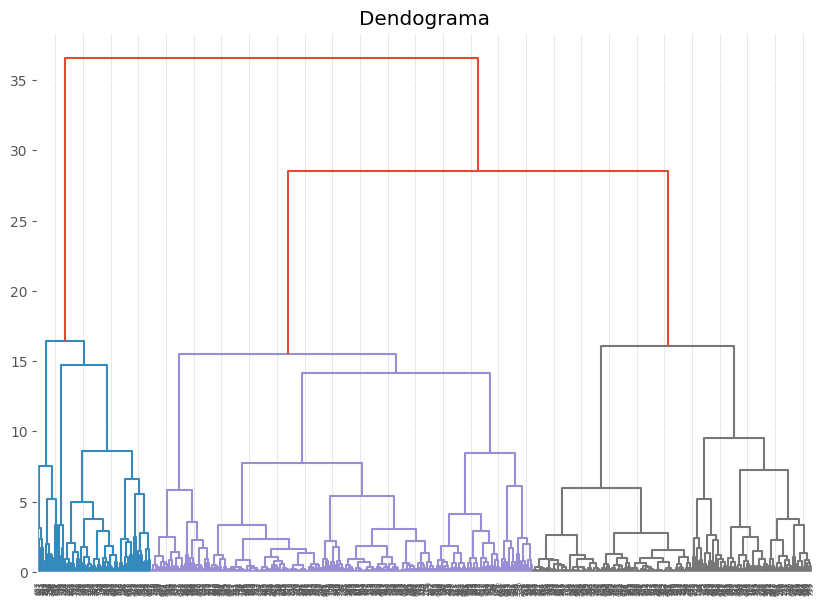

In [ ]:
# Generar dendograma
plt.figure(figsize=(10, 7))
plt.title("Dendograma")

dendograma = sch.dendrogram(sch.linkage(clustering_data_scaled, method="ward")) # El método ward se usa para minimizar la varianza intraclúster, es decir, minimizar la varianza de los datos dentro de un clúster.

Buscamos que la separación de los grupos de clusters sea 3, para esto, podemos colocar una línea de referencia en una altura de 17.

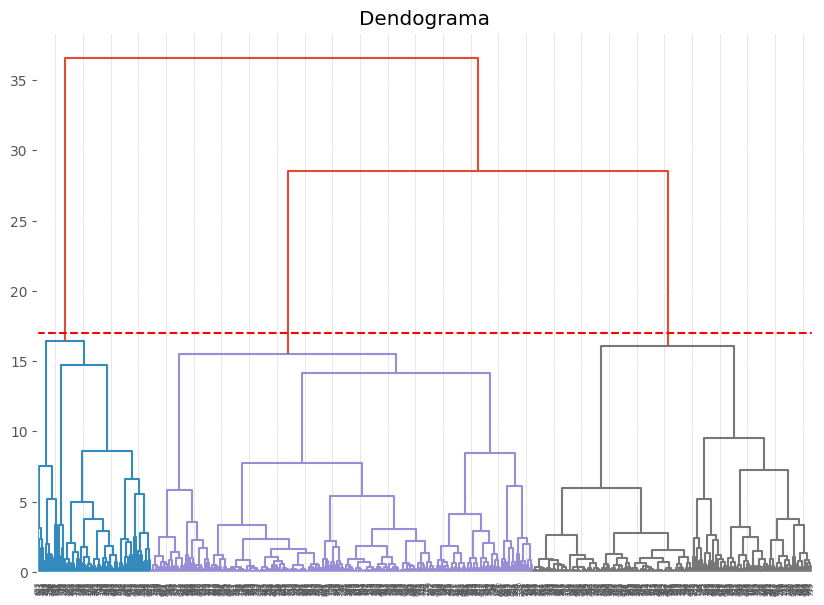

In [ ]:
# Graficar línea en el dendograma
plt.figure(figsize=(10, 7))
plt.title("Dendograma")

dendograma = sch.dendrogram(sch.linkage(clustering_data_scaled, method="ward"))

plt.axhline(y=17, color='r', linestyle='--')
plt.show()

## 4. Caracterización

En principio, vamos a añadir nuestra clasificación obtenida a nuestro dataset para ver cuales son los resultados.

In [ ]:
movies_df_aux['cluster'] = labels_3D
movies_df_aux.head()

,name,year,runtime,genre,rating,metascore,votes,gross,cluster
0,Wonder,I 2017,113,6,8.0,66.0,147185.0,132420000.0,2
1,Brokeback Mountain,2005,134,6,7.7,87.0,329316.0,83040000.0,0
2,Training Day,2001,122,5,7.7,69.0,399865.0,76630000.0,2
3,The Magnificent Seven,1960,128,0,7.7,74.0,89005.0,4910000.0,2
4,"O Brother, Where Art Thou?",2000,107,1,7.7,69.0,292711.0,45510000.0,2


Una vez ya tenemos nuestro dataset junto con la clasificación, realizaremos una caracterización por cada uno de los clusters, mostrando el dataset segmentado y una caracterización de los datos que tiene el mismo.

### Cluster 0

In [ ]:
cluster_0 = movies_df_aux[movies_df_aux['cluster'] == 0]
cluster_0.head()

,name,year,runtime,genre,rating,metascore,votes,gross,cluster
1,Brokeback Mountain,2005,134,6,7.7,87.0,329316.0,83040000.0,0
10,The Wind Rises,2013,126,2,7.8,83.0,76178.0,5210000.0,0
11,The Fugitive,1993,130,0,7.8,87.0,272333.0,183880000.0,0
12,A Very Long Engagement,2004,133,6,7.6,76.0,71418.0,6170000.0,0
13,Sing Street,2016,106,4,7.9,79.0,86902.0,3240000.0,0


In [ ]:
cluster_0.drop('cluster', axis=1).describe()

,runtime,genre,rating,metascore,votes,gross
count,382.000000,382.000000,382.000000,382.000000,382.000000,3.820000e+02
mean,121.052356,4.172775,7.937696,85.646597,223619.191099,3.230864e+07
std,26.707070,2.316548,0.248445,6.883982,200527.508179,4.316135e+07
min,66.000000,0.000000,7.600000,75.000000,25213.000000,1.000000e+04
25%,102.000000,3.000000,7.700000,80.000000,68354.500000,2.835000e+06
50%,118.000000,4.000000,7.900000,85.000000,149268.500000,1.377000e+07
75%,134.000000,6.000000,8.100000,90.000000,317172.000000,4.457500e+07
max,238.000000,13.000000,9.000000,100.000000,935555.000000,2.201600e+08


Vamos a realizar unos graficos dadas unas caracteristicas de los clusters para visualizar si existe una tendencia

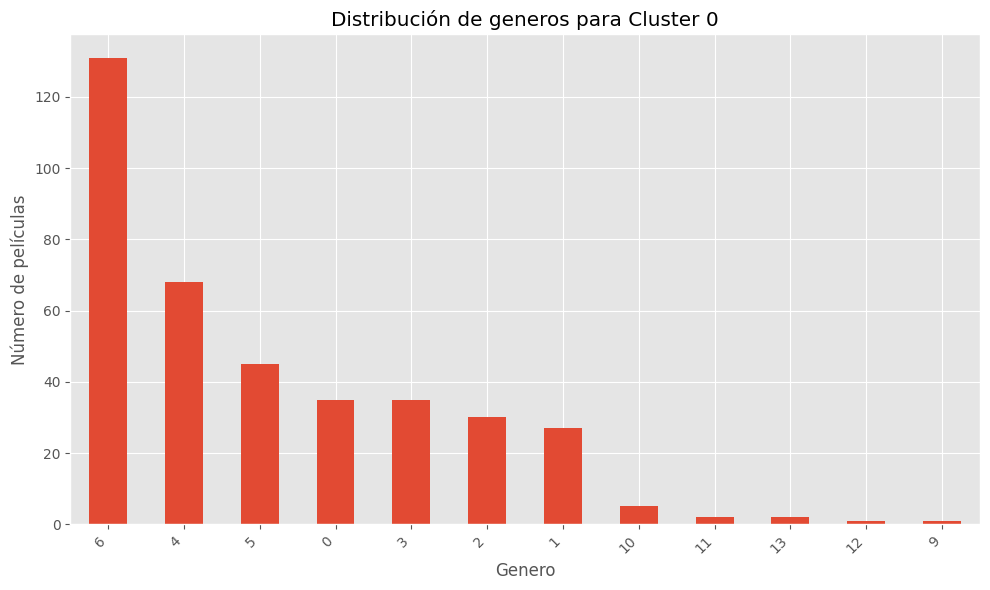

In [ ]:
import matplotlib.pyplot as plt

genre_counts = cluster_0['genre'].value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Distribución de generos para Cluster 0')
plt.xlabel('Genero')
plt.ylabel('Número de películas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

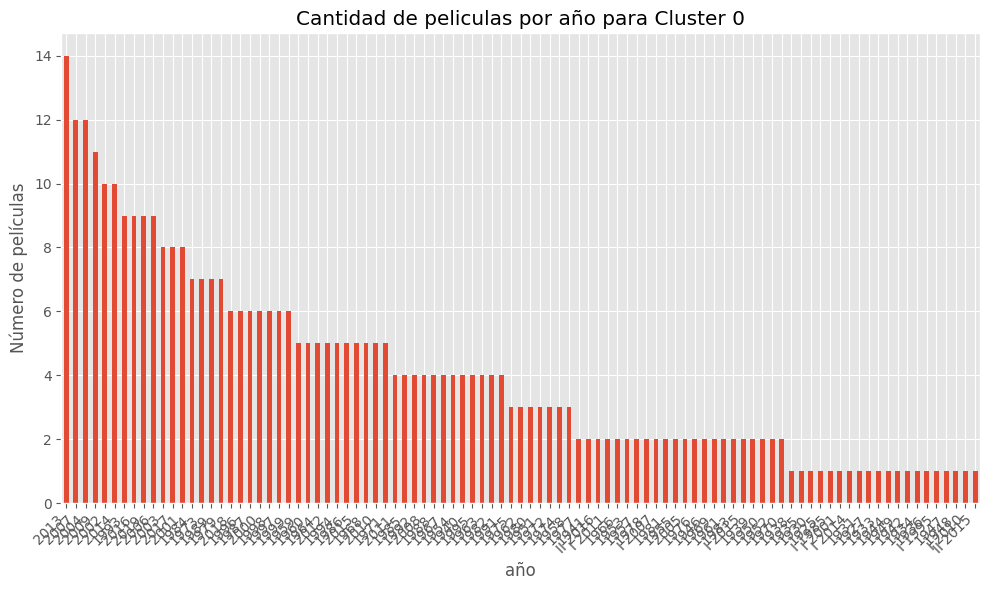

In [ ]:
import matplotlib.pyplot as plt

genre_counts = cluster_0['year'].value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Cantidad de peliculas por año para Cluster 0')
plt.xlabel('año')
plt.ylabel('Número de películas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

En este cluster, podemos ver como las películas pertenecientes a este grupo son películas que poseen valores que no sobresalen demasiado, estos encontrandose en las características promedio para los valores que se tienen. En el caso del rating, tenemos un promedio de 7.94, con mínimos de 7.6 y máximos de 9. Además de esto, en el caso del metascore, tenemos un promedio de 85.65, con mínimos de 75 y máximos de 100. Esto nos indica que son películas con buena calidad, pero que muchas no llegan a ser éxitos sobresalientes. Esta última consideración viene apoyada por una última característica, el gross (o beneficios generados), en comparación con el resto de clusters, resulta en un valor promedio. Así, podemos concluir que a este grupo pertenecen películas relativamente buenas, pero que no llegan a ser las más exitosas.

### Cluster 1

In [ ]:
cluster_1 = movies_df_aux[movies_df_aux['cluster'] == 1]
cluster_1.head()

,name,year,runtime,genre,rating,metascore,votes,gross,cluster
7,The Godfather: Part II,1974,202,5,9.0,90.0,1152912.0,57300000.0,1
9,Rogue One: A Star Wars Story,2016,133,0,7.8,65.0,567513.0,532180000.0,1
16,Iron Man,2008,126,0,7.9,79.0,959046.0,318410000.0,1
18,The Hobbit: The Desolation of Smaug,2013,161,1,7.8,66.0,610434.0,258370000.0,1
21,Toy Story 4,2019,100,2,7.7,84.0,212376.0,434040000.0,1


In [ ]:
cluster_1.drop('cluster', axis=1).describe()

,runtime,genre,rating,metascore,votes,gross
count,122.000000,122.000000,122.000000,122.000000,1.220000e+02,1.220000e+02
mean,131.540984,2.344262,8.157377,78.352459,9.190617e+05,2.627404e+08
std,26.839944,2.674553,0.394574,9.802953,4.291805e+05,1.591046e+08
min,81.000000,0.000000,7.600000,58.000000,2.123760e+05,2.334000e+07
25%,111.000000,0.000000,7.800000,71.250000,6.098040e+05,1.653275e+08
50%,130.000000,2.000000,8.100000,79.000000,8.763415e+05,2.362750e+08
75%,146.750000,4.750000,8.400000,85.000000,1.142368e+06,3.170700e+08
max,202.000000,11.000000,9.300000,100.000000,2.394059e+06,9.366600e+08


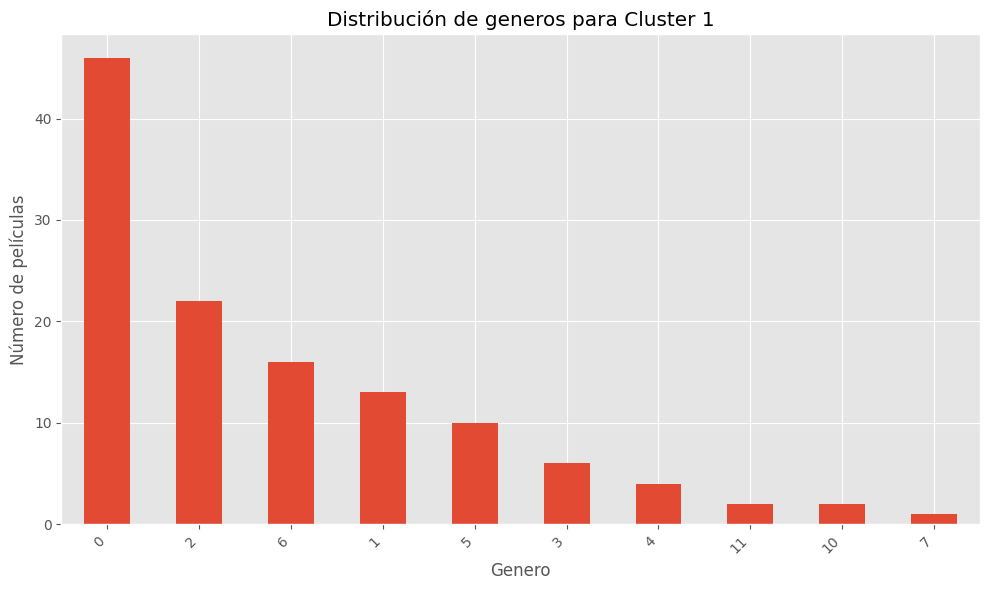

In [ ]:
import matplotlib.pyplot as plt

genre_counts = cluster_1['genre'].value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Distribución de generos para Cluster 1')
plt.xlabel('Genero')
plt.ylabel('Número de películas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

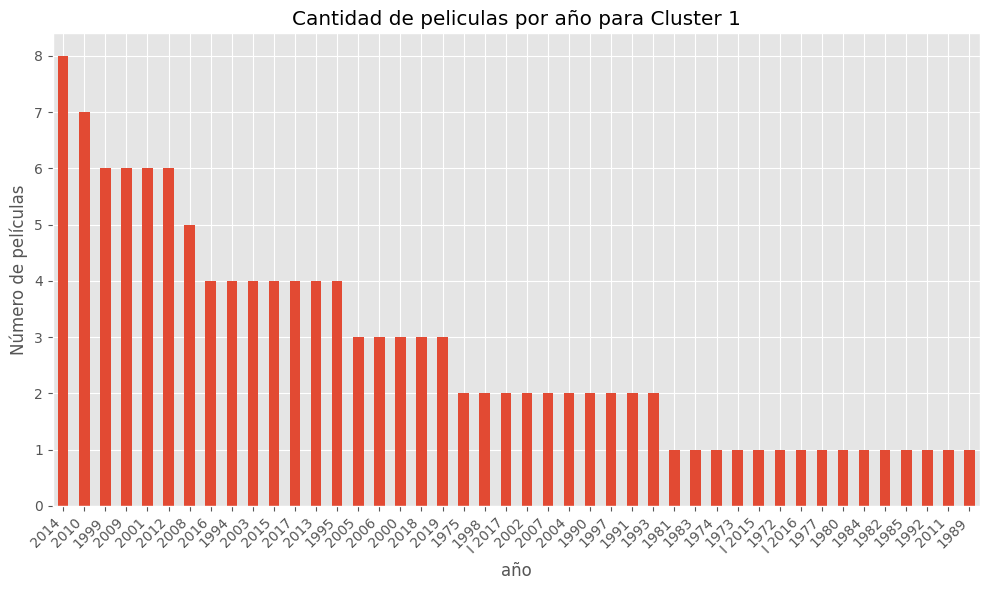

In [ ]:
import matplotlib.pyplot as plt

genre_counts = cluster_1['year'].value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Cantidad de peliculas por año para Cluster 1')
plt.xlabel('año')
plt.ylabel('Número de películas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

En este cluster resultan aparecer los grandes éxitos cuando estamos hablando de películas. Estamos hablando de un conjunto de películas que tienen un nivel elevado de votos y de ganancias. Además de que, en cuanto a su rating y su metascore, a pesar de que logran 8.1 (rating) y 78 (metascore), son aquellas películas que tienen los picos más altos, y con gran nivel de crítica.

### Cluster 2

In [ ]:
cluster_2 = movies_df_aux[movies_df_aux['cluster'] == 2]
cluster_2.head()

,name,year,runtime,genre,rating,metascore,votes,gross,cluster
0,Wonder,I 2017,113,6,8.0,66.0,147185.0,132420000.0,2
2,Training Day,2001,122,5,7.7,69.0,399865.0,76630000.0,2
3,The Magnificent Seven,1960,128,0,7.7,74.0,89005.0,4910000.0,2
4,"O Brother, Where Art Thou?",2000,107,1,7.7,69.0,292711.0,45510000.0,2
5,Sherlock Holmes,2009,128,0,7.6,57.0,590806.0,209030000.0,2


In [ ]:
cluster_2.drop('cluster', axis=1).describe()

,runtime,genre,rating,metascore,votes,gross
count,243.000000,243.000000,243.000000,243.000000,2.430000e+02,2.430000e+02
mean,122.786008,3.703704,7.826337,64.720165,2.613229e+05,4.847465e+07
std,23.847039,2.616435,0.210582,8.982759,2.136465e+05,5.319819e+07
min,72.000000,0.000000,7.600000,28.000000,2.658900e+04,0.000000e+00
25%,107.000000,1.000000,7.700000,60.500000,8.395250e+04,4.450000e+06
50%,120.000000,4.000000,7.800000,67.000000,2.039820e+05,3.248000e+07
75%,134.000000,6.000000,8.000000,72.000000,3.860845e+05,7.027500e+07
max,202.000000,13.000000,8.600000,76.000000,1.056159e+06,2.559600e+08


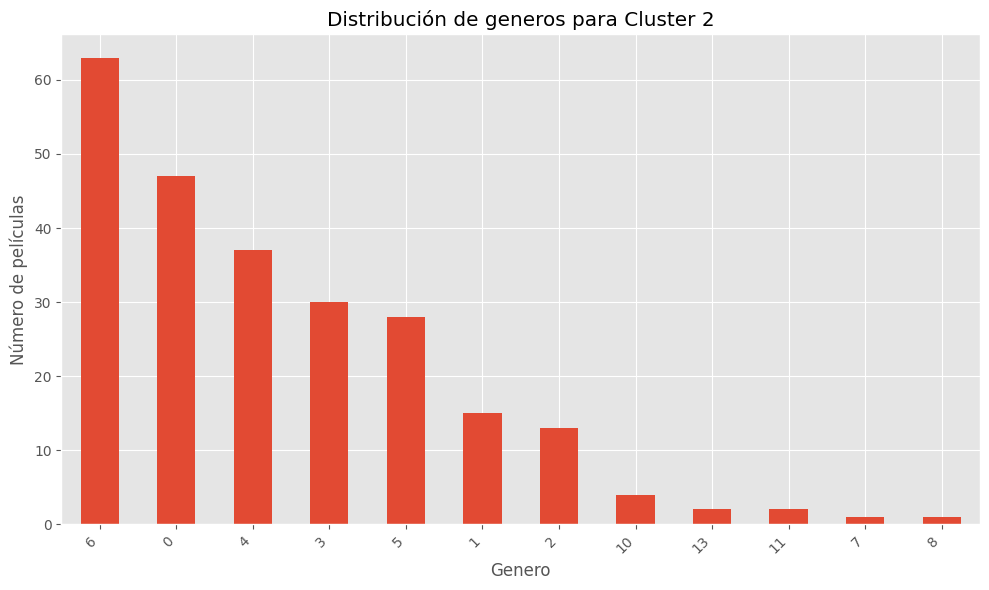

In [ ]:
import matplotlib.pyplot as plt

genre_counts = cluster_2['genre'].value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Distribución de generos para Cluster 2')
plt.xlabel('Genero')
plt.ylabel('Número de películas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

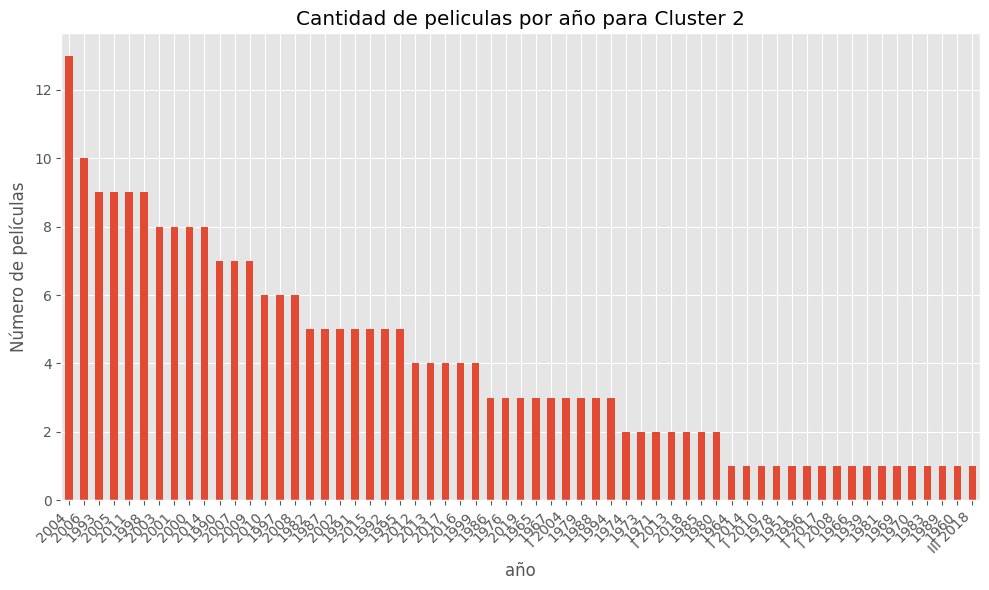

In [ ]:
import matplotlib.pyplot as plt

genre_counts = cluster_2['year'].value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Cantidad de peliculas por año para Cluster 2')
plt.xlabel('año')
plt.ylabel('Número de películas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Finalmente, en este cluster, tenemos las películas más criticadas negativamente por el público. Hablando un poco de sus características, tanto el rating como el metascore nos hablan de películas con calificaciones algo regulares, teniendo sus promedios en 7.8 y 64.7 respectivamente, calificaciones que son las menores de todas las obtenidas. Sin embargo, son películas que relativamente tienen unas ganancias un poco mejores con respecto al cluster 0, reflejando películas que posiblemente sean conocidas, pero que hayan decepcionado al público con respecto a lo que se esperaba de las mismas.

## 5. Análisis de Tendencias

A continuación vamos a realizar un breve análisis de algunas de las tendencias que pudemos deducir del análisis generado a lo largo de este notebook. Las listaremos en la siguiente lista que tratará de abordar la mayoría de los aspectos cubiertos por el dataset.

1. El volumen de votos está fuertemente correlacionado con el éxito comercial: Las películas del clúster 1 tienen un volumen muy alto de votos y también mayores ingresos brutos, mostrando que las películas más populares generan mayor discusión en plataformas como IMDb.
2. La calificación crítica de las películas no está relacionada con su éxito comercial: Las películas del clúster 0 y el clúster 2 reflejan dos fenómenos, mientras que en la una las calificaciones críticas son aceptables, generan la menor cantidad de ingresos, mientras que sucede lo contrario en el clúster 2. Esto podría estar ligado al resultado en cuanto a la expectativa de las películas.
3. La calidad percibida puede ser independiente de los ingresos: Mientras que los clústeres 0 y 1 incluyen películas con metascores altos, solo las del clúster 1 tienen ingresos altos. Esto destaca que algunas películas de alta calidad pueden ser más apreciadas en círculos específicos que en el mercado masivo.
4. Las películas con metascores más altos no siempre tienen calificaciones de audiencia proporcionalmente altas: En el clúster 0, las películas tienen metascores altos (superiores a 80 en promedio), pero las calificaciones de la audiencia no siempre superan el 7.7, lo que indica una posible desconexión entre la crítica profesional y la percepción del público.
5.La distribución de votos tiende a ser desigual entre los clústeres: Las películas en clústeres con menos ingresos y metascores promedio (como el clúster 2) tienen significativamente menos votos, esto puede ser debido a la menor exposición o interés del público, o a los nichos en los cuales las películas se ven envueltas.

